<a href="https://colab.research.google.com/github/MirandaCarou/Research-Intership-Memory/blob/main/QGANS_with_qubits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pylatexenc

In [2]:
!pip install qiskit
!pip install qiskit-aer
!pip install scikit-learn

  Using cached qiskit_aqua-0.9.5-py3-none-any.whl.metadata (2.6 kB)
  Using cached qiskit_terra-0.46.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached qiskit_ignis-0.7.1-py3-none-any.whl.metadata (10 kB)
  Using cached dlx-1.0.4.tar.gz (5.5 kB)
  Preparing metadata (setup.py) ... done
  Using cached docplex-2.29.241.tar.gz (645 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached fastdtw-0.3.4.tar.gz (133 kB)
  Preparing metadata (setup.py) ... done
  Using cached h5py-3.2.1.tar.gz (368 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... canceledERROR: Operation cancelled by user


In [3]:
from qiskit_aer import Aer
from qiskit.utils import *

# Load and preprocess the Iris dataset
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import numpy as np

iris = load_iris()
data = iris.data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)


In [45]:
# Set random seeds for reproducibility
algorithm_globals.random_seed = 123456
_ = torch.manual_seed(123456)  # suppress output

# Load the Iris dataset
iris = load_iris()
X = iris.data  # Features (4 dimensions)

# Normalize the features to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
X_normalized = scaler.fit_transform(X)

# Fix the number of dimensions and discretization number
num_dim = 4  # Number of features in the Iris dataset
num_discrete_values = 8  # Number of discrete values per feature

# Compute the number of qubits required
#num_qubits = 4
num_qubits = num_dim * int(np.log2(num_discrete_values))
print(f"Number of qubits required: {num_qubits}")

# Prepare a discrete distribution from the normalized Iris dataset
# Since the Iris dataset is already continuous, we discretize it
coords = np.linspace(0, 1, num_discrete_values)  # Range [0, 1] due to normalization
grid_elements = np.array(np.meshgrid(*[coords] * num_dim)).T.reshape(-1, num_dim)

# Compute probabilities for the discretized Iris dataset
# Here, we use a kernel density estimate (KDE) to approximate the PDF of the Iris dataset
from scipy.stats import gaussian_kde

kde = gaussian_kde(X_normalized.T)  # Transpose to match KDE input format
prob_data = kde(grid_elements.T)  # Evaluate KDE on the grid
prob_data = prob_data / np.sum(prob_data)  # Normalize to form a discrete distribution

# Print the shape of the probability distribution
print(f"Shape of the probability distribution: {prob_data.shape}")

Number of qubits required: 12
Shape of the probability distribution: (4096,)


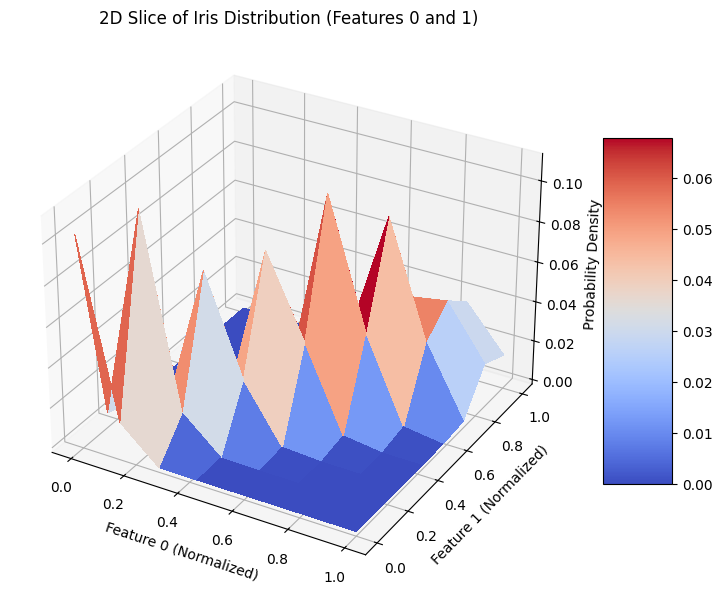

In [46]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

# Define the coordinates for the discretized grid
coords = np.linspace(0, 1, num_discrete_values)  # Range [0, 1] due to normalization

# Create a meshgrid for two features at a time
mesh_x, mesh_y = np.meshgrid(coords, coords)
grid_shape = (num_discrete_values, num_discrete_values)

# Reshape the probability distribution into a 4D grid
prob_grid_4d = np.reshape(prob_data, (num_discrete_values, num_discrete_values, num_discrete_values, num_discrete_values))

# Choose two features to visualize (e.g., feature 0 and feature 1)
feature_x = 0  # Sepal Length
feature_y = 1  # Sepal Width

# Marginalize over the other two features (feature 2 and feature 3)
prob_grid_2d = np.sum(prob_grid_4d, axis=(2, 3))

# Plot the 2D slice
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={"projection": "3d"})
surf = ax.plot_surface(mesh_x, mesh_y, prob_grid_2d, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel(f"Feature {feature_x} (Normalized)")
ax.set_ylabel(f"Feature {feature_y} (Normalized)")
ax.set_zlabel("Probability Density")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title(f"2D Slice of Iris Distribution (Features {feature_x} and {feature_y})")
plt.show()

##Definition of the quantum neural network ansatz
To implement the quantum generator, we choose a hardware efficient ansatz with repetitions. The ansatz implements $R_y, R_Z$ rotations and $C_X$ gates which takes a uniform distribution as an input state. Notably, for $k>1$ the generator’s parameters must be chosen carefully. For example, the circuit depth should be more than because higher circuit depths enable the representation of more complex structures. Here, we construct quite a deep circuit with a large number of parameters to be able to adequately capture and represent the distribution.

In [47]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2

qc = QuantumCircuit(num_qubits)
qc.h(qc.qubits)

ansatz = EfficientSU2(num_qubits, reps=6)
qc.compose(ansatz, inplace=True)

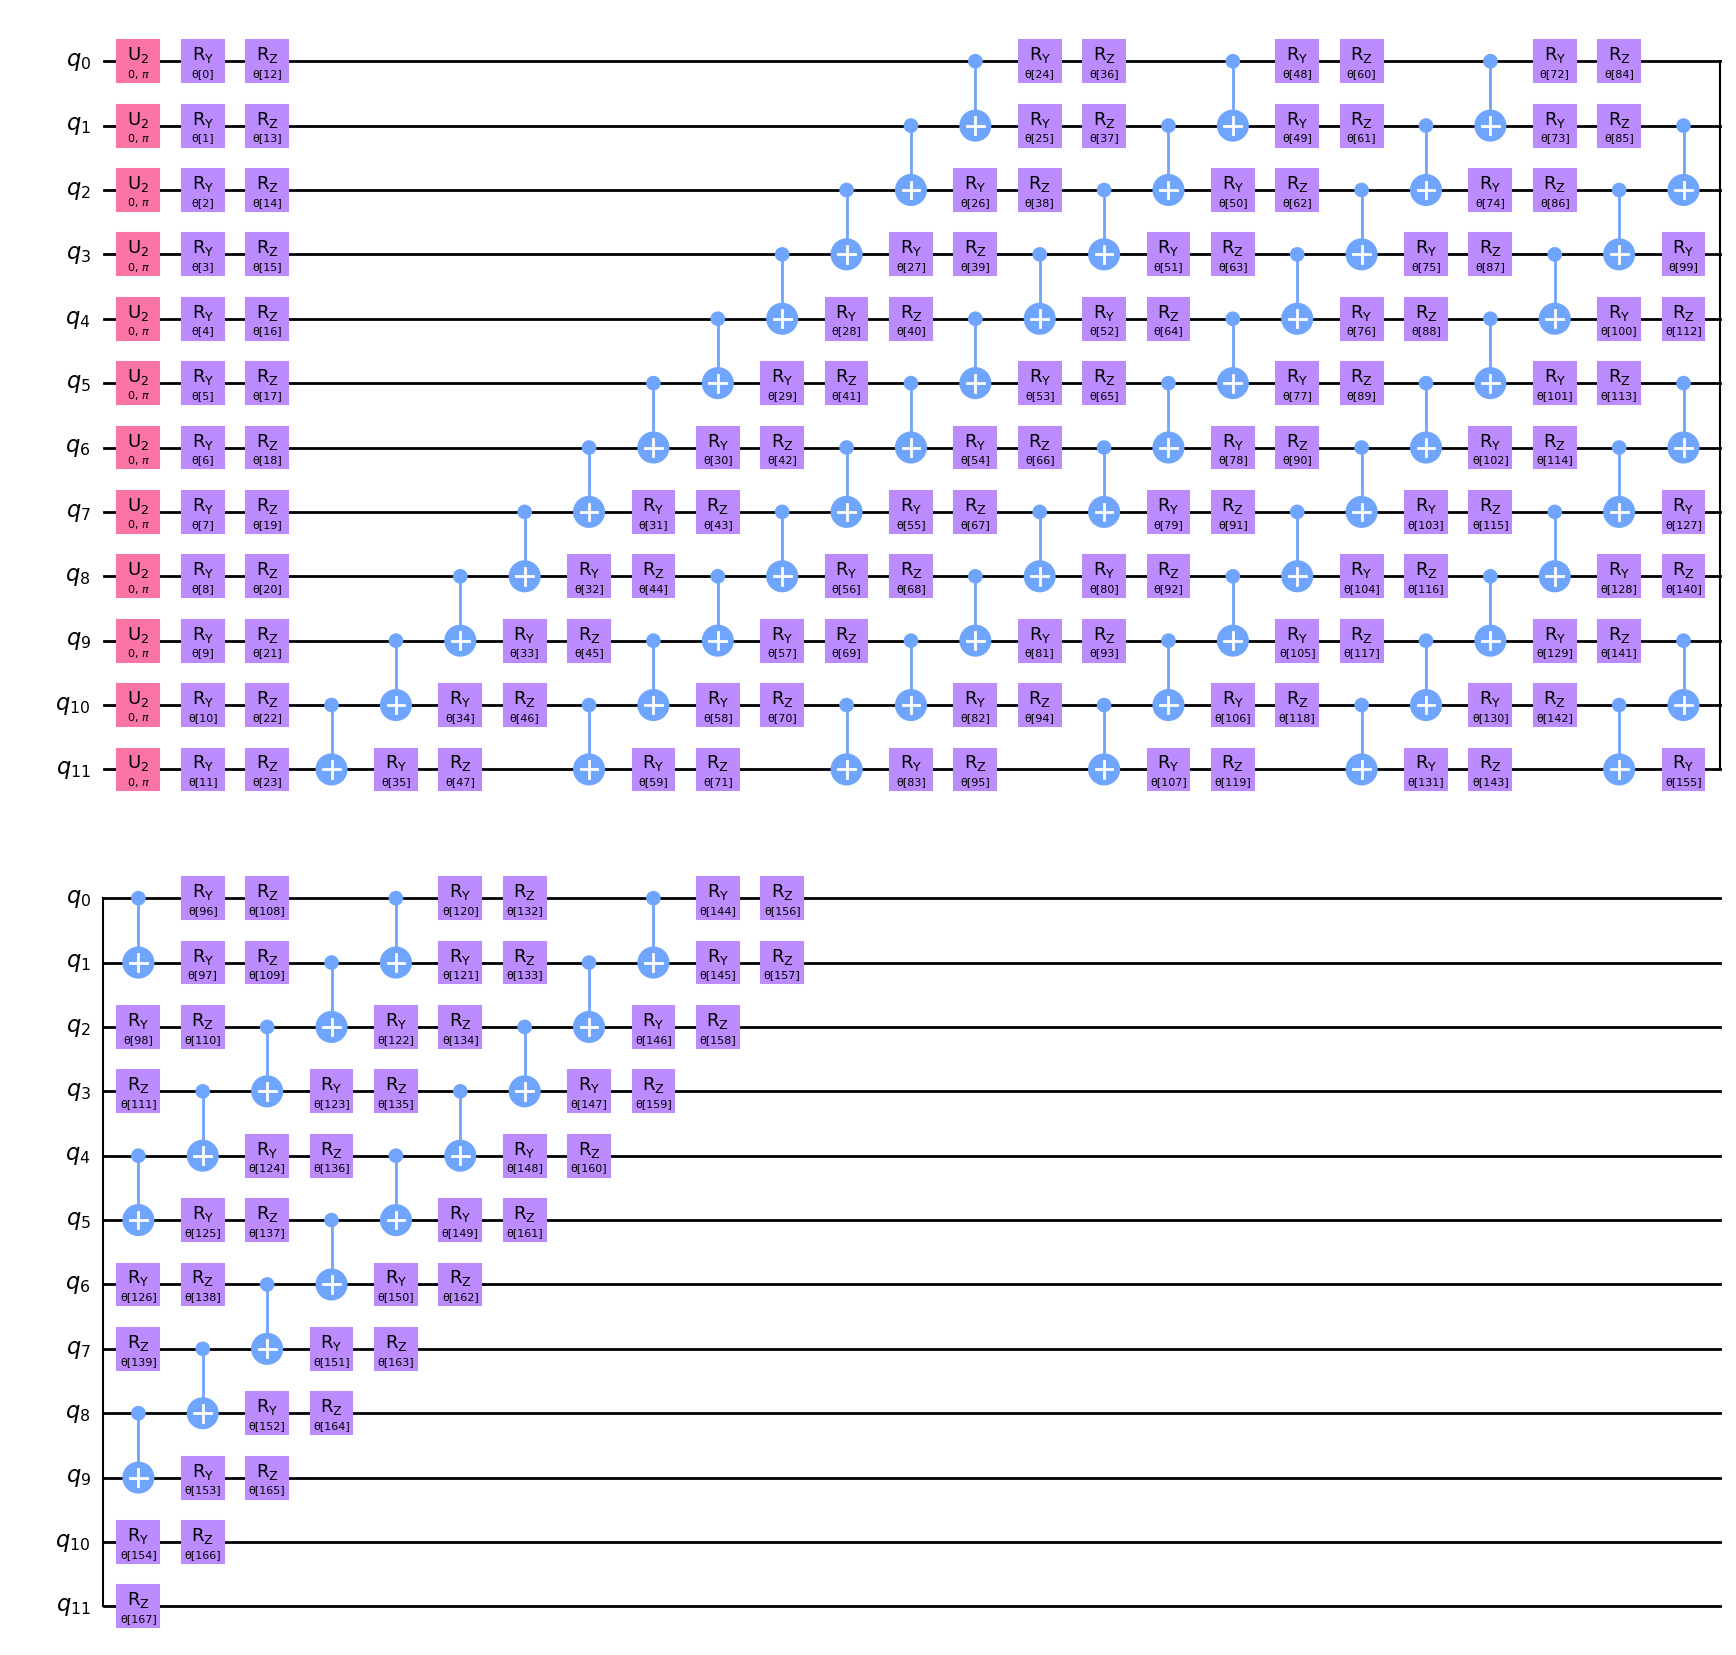

In [48]:
qc.decompose().draw(output="mpl", style="clifford")

In [49]:
qc.num_parameters

168

##Definition of the quantum generator
We start defining the generator by creating a sampler for the ansatz. The reference implementation is a statevector-based implementation, thus it returns exact probabilities as a result of circuit execution. In this case the implementation samples probabilities from the multinomial distribution constructed from the measured quasi probabilities.

In [50]:
from qiskit.primitives import StatevectorSampler as Sampler

sampler = Sampler()

Next, we define a function that creates the quantum generator from a given parameterized quantum circuit. Inside this function we create a neural network that returns the quasi probability distribution evaluated by the underlying Sampler. We fix initial_weights for reproducibility purposes. In the end we wrap the created quantum neural network in TorchConnector to make use of PyTorch-based training.

In [10]:
!pip install qiskit-machine-learning #

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.6/231.6 kB 4.5 MB/s eta 0:00:00


In [51]:
import torch
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN


def create_generator() -> TorchConnector:
    qnn = SamplerQNN(
        circuit=qc,
        sampler=sampler,
        input_params=[],
        weight_params=qc.parameters,
        sparse=False,
    )

    initial_weights = algorithm_globals.random.random(qc.num_parameters)
    return TorchConnector(qnn, initial_weights)

## Definition of the classical discriminator
Next, we define a PyTorch-based classical neural network that represents the classical discriminator. The underlying gradients can be automatically computed with PyTorch.

In [52]:
from torch import nn


class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 20)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear20 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear20(x)
        x = self.sigmoid(x)
        return x

In [53]:
generator = create_generator()
discriminator = Discriminator(num_dim)

##Setting up the Training Loop

  * A loss function for the generator and discriminator.

  * Optimizers for both.

  * A utility plotting function to visualize training process.

(Añadir info : https://qiskit-community.github.io/qiskit-machine-learning/tutorials/04_torch_qgan.html)

In [54]:
def adversarial_loss(input, target, w):
    bce_loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
    weighted_loss = w * bce_loss
    total_loss = -torch.sum(weighted_loss)
    return total_loss

## Definition of the optimizers
In order to train the generator and discriminator, we need to define optimization schemes. In the following, we employ a momentum based optimizer called Adam, see Kingma et al., Adam: A method for stochastic optimization for more details.

In [55]:
from torch.optim import Adam

lr = 0.01  # learning rate
b1 = 0.7  # first momentum parameter
b2 = 0.999  # second momentum parameter

generator_optimizer = Adam(generator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)
discriminator_optimizer = Adam(
    discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005
)

## Visualization of the training process

We will visualize what is happening during the training by plotting the evolution of the generator’s and the discriminator’s loss functions during the training, as well as the progress in the relative entropy between the trained and the target distribution. We define a function that plots the loss functions and relative entropy. We call this function once an epoch of training is complete.

Visualization of the training process begins when training data is collected across two epochs.

In [56]:
from IPython.display import clear_output


def plot_training_progress():
    # we don't plot if we don't have enough data
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Generator Loss
    ax1.set_title("Loss")
    ax1.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax1.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax1.legend(loc="best")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.grid()

    # Relative Entropy
    ax2.set_title("Relative entropy")
    ax2.plot(entropy_values)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Relative entropy")
    ax2.grid()

    plt.show()

##Model Training

In the training loop we monitor not only loss functions, but relative entropy as well. The relative entropy describes a distance metric for distributions. Hence, we can use it to benchmark how close/far away the trained distribution is from the target distribution.

Now, we are ready to train our model. It may take some time to train the model so be patient.

1. **Generator Loss**: This helps you track how well the generator is learning to produce realistic data over time. Lower generator loss typically indicates better performance.

2. **Discriminator Loss**: This also gives an idea of how well the discriminator is distinguishing between real and generated data. You want both the generator and discriminator to improve as the training progresses.

3. **Entropy**: You are computing the entropy of the generated data and comparing it to the probability distribution of the real data. Lower entropy indicates that the generated distribution is more similar to the real distribution.

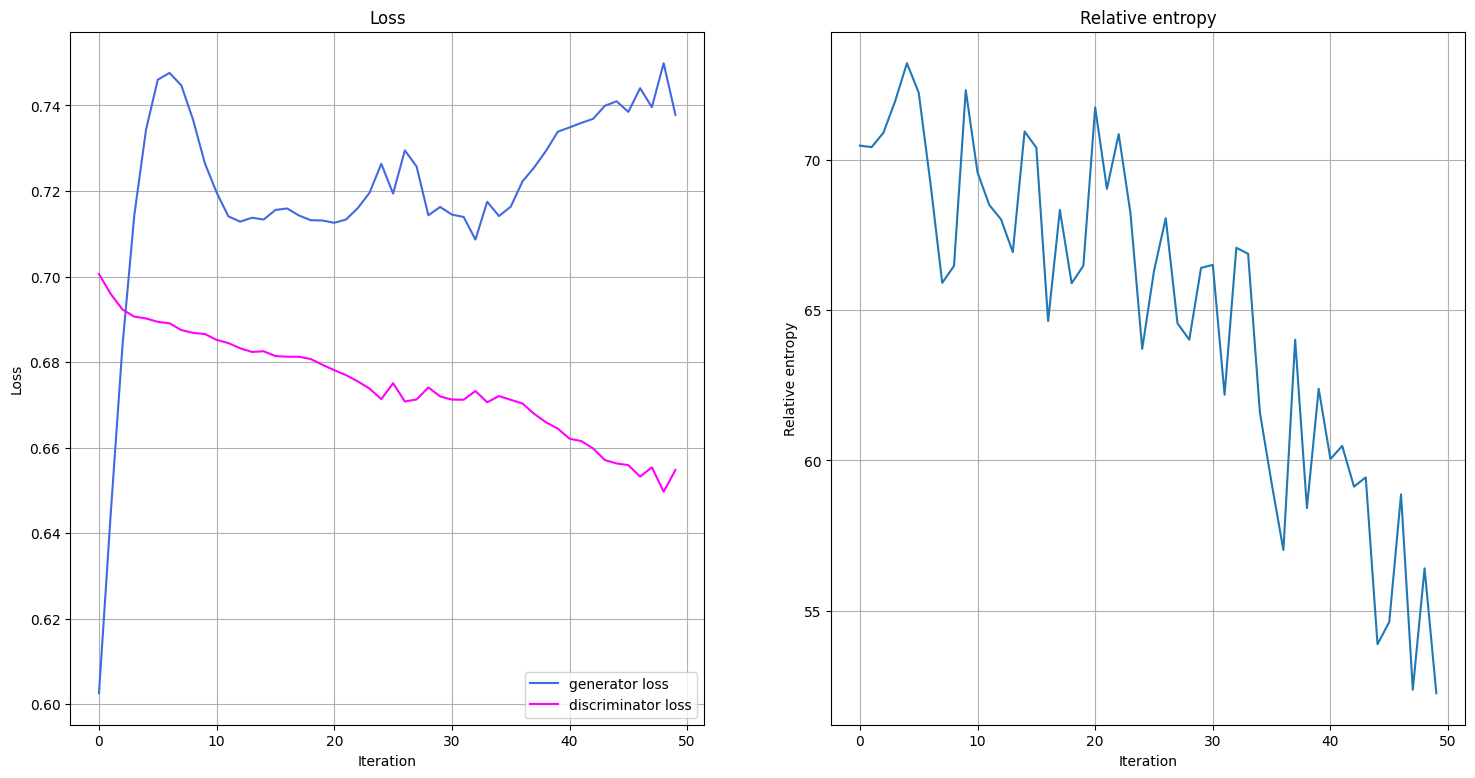

Fit in 1890.69 sec


In [57]:
import time
from scipy.stats import multivariate_normal, entropy
from IPython.display import clear_output
import matplotlib.pyplot as plt # Importing the matplotlib library

n_epochs = 50

num_qnn_outputs = num_discrete_values**num_dim

generator_loss_values = []
discriminator_loss_values = []
entropy_values = []

start = time.time()
for epoch in range(n_epochs):

    valid = torch.ones(num_qnn_outputs, 1, dtype=torch.float)
    fake = torch.zeros(num_qnn_outputs, 1, dtype=torch.float)

    # Configure input
    real_dist = torch.tensor(prob_data, dtype=torch.float).reshape(-1, 1)

    # Configure samples
    samples = torch.tensor(grid_elements, dtype=torch.float)
    disc_value = discriminator(samples)

    # Generate data
    gen_dist = generator(torch.tensor([])).reshape(-1, 1)

    # Train generator
    generator_optimizer.zero_grad()
    generator_loss = adversarial_loss(disc_value, valid, gen_dist)

    # store for plotting
    generator_loss_values.append(generator_loss.detach().item())

    generator_loss.backward(retain_graph=True)
    generator_optimizer.step()

    # Train Discriminator
    discriminator_optimizer.zero_grad()

    real_loss = adversarial_loss(disc_value, valid, real_dist)
    fake_loss = adversarial_loss(disc_value, fake, gen_dist.detach())
    discriminator_loss = (real_loss + fake_loss) / 2

    # Store for plotting
    discriminator_loss_values.append(discriminator_loss.detach().item())

    discriminator_loss.backward()
    discriminator_optimizer.step()

    entropy_value = entropy(gen_dist.detach().squeeze().numpy(), prob_data)
    entropy_values.append(entropy_value)

    plot_training_progress()

elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} sec")

In [74]:
from sklearn.decomposition import PCA

# Assuming gen_samples is the generated samples and real_samples are the real samples
#pca = PCA(n_components=2)
#pca_real = pca.fit_transform(prob_data.reshape(-1, 2))
#pca_gen = pca.transform(gen_dist.detach().numpy())

#plt.scatter(pca_real[:, 0], pca_real[:, 1], label='Real Data')
#plt.scatter(pca_gen[:, 0], pca_gen[:, 1], label='Generated Data')
#plt.legend()
#plt.show()

## Results: Cumulative Density Functions

In [64]:
from scipy.stats import wasserstein_distance
from scipy.special import kl_div

w_distance = wasserstein_distance(prob_data, gen_dist.detach().numpy().flatten())
print(f"Wasserstein Distance: {w_distance}")

kl_divergence = np.sum(kl_div(prob_data, gen_dist.detach().numpy().flatten()))
print(f"KL Divergence: {kl_divergence}")

mse = np.mean((prob_data - gen_dist.detach().numpy().flatten()) ** 2)
print(f"Mean Squared Error: {mse}")

Wasserstein Distance: 0.00019496515119299667
KL Divergence: inf
Mean Squared Error: 2.074783912794167e-06


qGAN is performing well in terms of Wasserstein distance and MSE, but the KL divergence indicates that there are regions where the generated distribution does not fully match the real distribution. By addressing the zero-probability issue and experimenting with hyperparameters, you can further improve the performance of your qGAN.

In [73]:
# Add a small constant to avoid zero probabilities
fix_gen_dist = gen_dist.detach().numpy().flatten() + 1e-10
kl_divergence = np.sum(kl_div(prob_data, fix_gen_dist))

kl_divergence = np.sum(kl_div(prob_data, fix_gen_dist))
print(f"KL Divergence: {kl_divergence}")



KL Divergence: 12.870939572191464


In [75]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

'''
# Assuming `generated_probabilities` is the output of the generator
with torch.no_grad():
    generated_probabilities = generator().numpy()

# Ensure the size of `generated_probabilities` matches the expected grid shape
expected_size = num_discrete_values ** num_dim
if generated_probabilities.size != expected_size:
    raise ValueError(f"Size of generated_probabilities ({generated_probabilities.size}) does not match expected size ({expected_size}).")

# Reshape the generated probabilities into the grid shape
grid_shape = (num_discrete_values, num_discrete_values)
gen_prob_grid = np.reshape(generated_probabilities, grid_shape)

# Compute the cumulative sum for the generated probabilities
gen_prob_grid = np.cumsum(gen_prob_grid, axis=0)
gen_prob_grid = np.cumsum(gen_prob_grid, axis=1)

# Reshape the true probabilities into the grid shape
real_prob_grid = np.reshape(prob_data, grid_shape)

# Compute the cumulative sum for the true probabilities
real_prob_grid = np.cumsum(real_prob_grid, axis=0)
real_prob_grid = np.cumsum(real_prob_grid, axis=1)

# Create the plot
fig = plt.figure(figsize=(18, 9))

# Generated CDF
ax1 = fig.add_subplot(1, 3, 1, projection="3d")
ax1.set_title("Generated CDF")
ax1.plot_surface(mesh_x, mesh_y, gen_prob_grid, linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax1.set_zlim(-0.05, 1.05)

# True CDF
ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax2.set_title("True CDF")
ax2.plot_surface(mesh_x, mesh_y, real_prob_grid, linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax2.set_zlim(-0.05, 1.05)

# Difference between CDFs
ax3 = fig.add_subplot(1, 3, 3, projection="3d")
ax3.set_title("Difference between CDFs")
ax3.plot_surface(
    mesh_x, mesh_y, real_prob_grid - gen_prob_grid, linewidth=2, antialiased=False, cmap=cm.coolwarm
)
ax3.set_zlim(-0.05, 0.1)

plt.show() '''

'\n# Assuming `generated_probabilities` is the output of the generator\nwith torch.no_grad():\n    generated_probabilities = generator().numpy()\n\n# Ensure the size of `generated_probabilities` matches the expected grid shape\nexpected_size = num_discrete_values ** num_dim\nif generated_probabilities.size != expected_size:\n    raise ValueError(f"Size of generated_probabilities ({generated_probabilities.size}) does not match expected size ({expected_size}).")\n\n# Reshape the generated probabilities into the grid shape\ngrid_shape = (num_discrete_values, num_discrete_values)\ngen_prob_grid = np.reshape(generated_probabilities, grid_shape)\n\n# Compute the cumulative sum for the generated probabilities\ngen_prob_grid = np.cumsum(gen_prob_grid, axis=0)\ngen_prob_grid = np.cumsum(gen_prob_grid, axis=1)\n\n# Reshape the true probabilities into the grid shape\nreal_prob_grid = np.reshape(prob_data, grid_shape)\n\n# Compute the cumulative sum for the true probabilities\nreal_prob_grid = np.